Several notes on SEI models:
1. In "reaction limited" smallest L_sei_0 can be used is 1e-12.
2. "electron-migration limited" for smalle L_sei_0 produce error and for relatively large L_sei_0 > 4e-9 at some point L_sei decrease. I have noticed tht overpotntial always must be negative [Tang et al. 2012](https://iopscience.iop.org/article/10.1149/2.025211je). So if we make it  postive we get postitive L_sei for any L_sei_0.
3. L_sei in "ec reaction limited" model increase gradually, then nradpidaly, and at some sgate become 

In [8]:
# %cd /home/kawamanmi/PyBaMM
import pybamm
import numpy as np
import matplotlib.pyplot as plt
param = pybamm.ParameterValues("Chen2020")
# param = pybamm.ParameterValues("ORegan2022")
# param

In [9]:
param['Initial inner SEI thickness [m]'] = 5e-9
param['Initial outer SEI thickness [m]'] = 5e-9
# param['Inner SEI open-circuit potential [V]'] = 0.3
# param

In [10]:

cycle_no = 2
exp_CCCV = pybamm.Experiment(
    [("Charge at C/10 until 4.2 V",
      "Rest for 10 hours",
      "Discharge at C/10 until 2.5 V",
      "Rest for 10 hours",
      )] * cycle_no
)

In [11]:
from os import name


sei_models = ["electron-migration limited"]

# sei_models = ["reaction limited", "solvent-diffusion limited",    "interstitial-diffusion limited"]
# sei_models = ["reaction limited", "electron-migration limited",
#   "interstitial-diffusion limited",  "solvent-diffusion limited", "ec reaction limited"]
# Diffferent SEI models can be used, by setting the index of sei_models


name_models = ["SPM"]
models_SPM = [pybamm.lithium_ion.SPM(options={
    "SEI": sei_models[index],
    "SEI porosity change": "true",
},
    name=sei_models[index]) for index in range(len(sei_models))
]

In [12]:
# models_SPM[0].variable_names()
# pybamm.settings.max_y_value = 1000000

In [13]:
# please note that the size of sims will be equal to the number of models times the number of experiments
from pybamm.models import event


solver = pybamm.CasadiSolver(mode="safe")
# solver = pybamm.ScipySolver(atol=1e-8, rtol=1e-8)
# solver = pybamm.IDAKLUSolver()
sims_SPM = [pybamm.Simulation(model, parameter_values=param,
                              experiment=exp_CCCV, solver=solver) for model in models_SPM]

In [14]:
sols_SPM = [sim.solve(initial_soc=0) for sim in sims_SPM]

In [15]:
# Vaiables to be postprocessed, you can add as many as output variables to the following list
# you can find the list variables to be be output by typing model name dot varaible_name() e.g. here, models[0].variable_names()
out_vars = [  # 'X-averaged negative particle surface concentration [mol.m-3]',
    # "Voltage [V]",
    # 'X-averaged negative SEI thickness [m]',
    'Discharge capacity [A.h]'
    # 'Total capacity lost to side reactions [A.h]',
    # 'Loss of lithium to SEI [mol]',
    # 'X-averaged inner SEI thickness [m]',
    # 'X-averaged outer SEI thickness [m]',
    # 'X-averaged negative electrode porosity',
]

# Label for the output variables y-axis in the plots
yaxis_labels = ["SEI_thickness",
                'Total capacity lost to side reactions [A.h]', 'Total lithium in particles', 'X-averaged inner SEI thickness [m]',
                'X-averaged outer SEI thickness [m]',]

In [16]:

# from matplotlib import lines

# for sol in sols_SPM:  # loop through the solutions of the DFN models
#     LS_cycles = [sol.cycles[k].steps[2]['X-averaged SEI thickness [m]'].entries[-1]
#                  for k in range(cycle_no)]
#     plt.scatter(np.arange(1, cycle_no+1), LS_cycles,
#                 label=models_SPM[sols_SPM.index(sol)].name)
# plt.xlabel("Cycle number")
# plt.ylabel("SEI thickness [m]")
# plt.legend()
# plt.show()

1


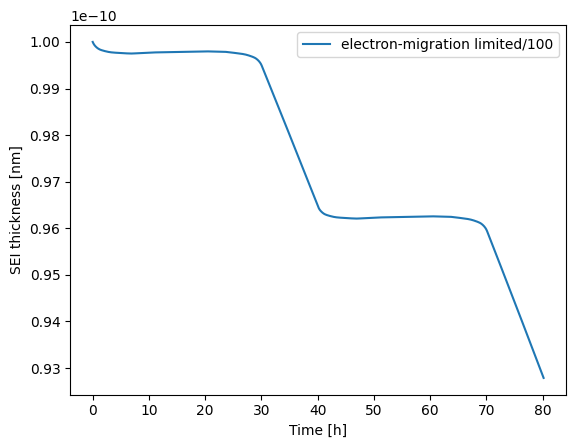

In [17]:
# plt.plot(sols_SPM[0].t, sols_SPM[0]
#          ['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries)
# plt.show()
dd = len(sei_models)
print(dd)
# for j in range(dd):
#     plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#              ['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries, label=models_SPM[j].name)
# plt.legend()
# plt.show()

# for j in range(dd):
#     if (j == dd):
#         plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#                  ['X-averaged negative electrode SEI film overpotential [V]'].entries, label=models_SPM[j].name)
#     else:
#         plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#                  ['X-averaged negative electrode SEI film overpotential [V]'].entries, label=models_SPM[j].name)
# plt.legend()
# plt.show()

for j in range(dd):
    if (j == dd-1):
        plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
                 ['X-averaged negative total SEI thickness [m]'].entries/100, label=models_SPM[j].name + "/100")
    else:
        plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
                 ['X-averaged negative total SEI thickness [m]'].entries, label=models_SPM[j].name)
plt.xlabel("Time [h]")
plt.ylabel("SEI thickness [nm]")
plt.legend()
plt.show()

In [18]:
import time
from pybamm.step.steps import current


SoC_s = sols_SPM[0].cycles[0]['Discharge capacity [A.h]'].entries
vols_s = sols_SPM[0].cycles[0]["Voltage [V]"].entries


for j in range(cycle_no):
    for sol in sols_SPM:  # loop through the solutions of the DFN models
        total_capacity_lost = sol.cycles[j]['Total capacity lost to side reactions [A.h]'].entries
        plt.plot(sol.cycles[j]["Time [h]"].entries, total_capacity_lost,
                 label=sei_models[sols_SPM.index(sol)] + str(j))
# plt.xlabel("SOC [%]")
# plt.ylabel("Voltage [V]")
plt.legend()
# plt.title("Cycle " + sei_models[sols_SPM.index(sol)])
plt.show()

AttributeError: 'ProcessedVariable' object has no attribute 'enteries'

In [ ]:
from pyparsing import line


line_style = ["-", ":"]
for sol in sols_SPM:  # loop through the solutions of the DFN models
    for j in range(cycle_no):
        negative_current_indices = sol.cycles[j]['Current [A]'].entries < 0
        SoC = sol.cycles[j]['Throughput capacity [A.h]'].entries
        vol = sol.cycles[j]["Voltage [V]"].entries
        plt.plot(SoC, vol,
                 label=sei_models[sols_SPM.index(sol)] + " cycle " + str(j+1), linestyle=line_style[j])
plt.xlabel('Throughput capacity [A.h]', fontsize=14)
plt.ylabel("Voltage [V]", fontsize=14)
plt.legend()
# plt.title("Cycle " + sei_models[sols_SPM.index(sol)])
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Create a figure and axis for the main plot
# fig, ax_main = plt.subplots()

# # Loop through cycles and solutions
# for sol in sols_SPM:
#     for j in range(cycle_no):
#         negative_current_indices = sol.cycles[j]['Current [A]'].entries < 0
#         SoC = sol.cycles[j]['Discharge capacity [A.h]'].entries[negative_current_indices]
#         vol = sol.cycles[j]["Voltage [V]"].entries[negative_current_indices]
#         ax_main.plot(np.abs(SoC) / 5 * 100, vol,
#                      label=sei_models[sols_SPM.index(sol)] + " cycle " + str(j + 1))

# # Set labels and legend for the main plot
# ax_main.set_xlabel("SOC [%]")
# ax_main.set_ylabel("Voltage [V]")
# ax_main.legend()

# # Create a subplot for magnification
# # Adjust the coordinates and size as needed
# ax_magnify = plt.axes([0.2, 0.6, 0.25, 0.25])

# # Plot the magnified section (voltage between 2.5 and 2.75)

# for sol in sols_SPM:
#     for j in range(cycle_no):
#         negative_current_indices = sol.cycles[j]['Current [A]'].entries < 0
#         SoC = sol.cycles[j]['Discharge capacity [A.h]'].entries[negative_current_indices]
#         vol = sol.cycles[j]["Voltage [V]"].entries[negative_current_indices]

#         # Only plot the desired voltage range in the magnified subplot
#         voltage_range_mask = (vol >= 2.5) & (vol <= 2.75)
#         ax_magnify.plot(np.abs(SoC[voltage_range_mask]) /
#                         5 * 100, vol[voltage_range_mask])

# # Set labels for the magnified subplot
# ax_magnify.set_xlabel("SOC [%]")
# ax_magnify.set_ylabel("Voltage [V]")
# ax_magnify.set_title("Magnified View (Voltage between 2.5 and 2.75)")

# # Show the plots
# plt.show()

In [ ]:
# from matplotlib import lines


# for out_var in out_vars:  # Loop through the output variables
#     for sol in sols_SPM:  # loop through the solutions of the SPM models
#         plt.plot(sol['Time [h]'].entries, sol[out_var].entries,
#                  linestyle='--',
#                  label=models_SPM[sols_SPM.index(sol)].name)

#     plt.xlabel("Time [h]")
#     plt.ylabel(yaxis_labels[out_vars.index(out_var)])
#     plt.legend()
#     plt.show()